In [1]:
from os.path import join as pjoin
import sys
import os
import numpy as np
import math
import math as mt
import matplotlib.pyplot as plt
import logging
import configparser
import copy
import errno
from scipy.integrate import ode, trapz
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)


In [2]:
###########################################################################
###################### classes, routines ##################################

class DetSolver:
    """
    General class for deterministic propagation of population dynamical models.
    """

    def __init__(self, model=None, tbeg=None, tend=None, dt=None, method='adams', rtol=1e-12, order=12, ic=None): #method='bdf' method='adams'
        self.model=model
        self.tbeg = tbeg
        self.tend = tend
        self.dt = dt
        self.method = method
        self.rtol = rtol
        self.order = order
        
        if ic:
            self.model.ic = ic

    def propagate(self): #, rtol=1e-12, order=12):

        if hasattr(self.model, "jac"):
            w_jac = True
            sol = ode(self.model.f, self.model.jac).set_integrator('lsoda', method=self.method, with_jacobian=w_jac, rtol=self.rtol, order=self.order)
        else:
            w_jac = False
            sol = ode(self.model.f).set_integrator('vode', method=self.method, with_jacobian=w_jac)
        sol.set_initial_value(self.model.ic, self.tbeg)
        t_seq = [ ]; pops_seq = [ ]
        ind = -1
        while sol.successful() and sol.t<self.tend: # #
            ind += 1           
            self.model.pops = sol.y[:]
            pops_seq.append(sol.y)
            t_seq.append(sol.t)
            sol.integrate(sol.t+self.dt)

        t_ar = np.array(t_seq, 'd')
        pops_ar = np.array(pops_seq)
        return t_ar, pops_ar

    def propagate_mpop(self, rtol=1e-12, order=12):

        sol = ode(self.model.f).set_integrator('vode', method=self.method, with_jacobian=False, rtol=rtol, order=order)
        #transform the initial value array in the format which scipy.integrate.ode understands
        #that is, flatten it appropriately
        #t_seq = [ self.tbeg ];
        #pops_seq = [self.model.ic]
        t_seq = [ ]; pops_seq = [ ]
        y_seq = []
        
        nsp = self.model.n_spec
        npa = self.model.n_patch

        neq = nsp*npa
        #ic1d = np.ones(neq, 'd')
        ic1d = self.model.ic.transpose().flatten()
            
        sol.set_initial_value(ic1d, self.tbeg)
        ind = -1
        while sol.successful() and sol.t<self.tend: # #
            
            t_seq.append(sol.t)
            #update self.model.pops
            ieq = -1
            ind += 1
            #if ind==1:
            #    print "metapop", "sol.y[:] at ind=1", sol.y[:]
            #convert from 1d array sol.y to the 2d array self.model.pops
            ###check if this is correct!
            for ipa in range(npa): #loop through all patches
                for isp in range(nsp): #loop through all species in the patch ipa
                    ieq += 1
                    self.model.pops[isp,ipa] = sol.y[ieq]
            #         # print "isp", isp, "ipa", ipa
            #         # print "self.model.pops[isp,ipa]", self.model.pops[isp,ipa]
            #         # print "ieq", ieq
            #         # print "sol.y[ieq]", sol.y[ieq]
            # print "these should be equal, but just the array reshaped"
            # print "self.model.pops", self.model.pops
            # print "sol.y", sol.y ##this is correct! :)
            #pops_seq.append(self.model.pops)
            y_seq.append(sol.y)
            sol.integrate(sol.t+self.dt)

        y_ar = np.array(y_seq, 'd')

        pops_shape = self.model.pops.shape
        #pops = np.zeros(pops_shape, 'd')

        for y in y_ar:
            pops = np.zeros(pops_shape, 'd')
            ieq = -1
            for ipa in range(npa): #loop through all patches
                for isp in range(nsp): #loop through all species in the patch ipa
                    ieq += 1
                    pops[isp,ipa] = y[ieq]
            pops_seq.append(pops)      
            
        #convert y_ar to pops_ar

        t_ar = np.array(t_seq, 'd')
        pops_ar = np.array(pops_seq, 'd')

        return t_ar, pops_ar


class DetModel:
    """
    Class for describing a deterministic population dynamical model.
    *ic* -- sequence of initial condition values
    *pars* -- dictionary of model parameters
    """
    def __init__(self, ic=None, pars=None):
        self.ic = np.array(ic, 'd')
        self.n_spec = self.ic.shape[0]
        try:
            self.n_patch = self.ic.shape[1]
        except IndexError:
            self.n_patch = 0
        self.pops = self.ic[:] #[]
        for key, val in zip(list(pars.keys()), list(pars.values())):
            setattr(self, key, val)
        self.config = configparser.ConfigParser()
        pars['ic'] = self.ic
        self.pars = copy.copy(pars)
        pars_copy = copy.copy(pars)
        self.add_params(section="general", param_dict=pars_copy)
        
    def write_params(self, pfile):
        """
        Write simulation parameters to a file.
        The parameters can then be extracted by read_params method (not implemented yet).
        """
        
        if hasattr(self, 'config'):
            outfile = open(pfile, 'w')
            self.config.write(outfile)
            outfile.close()
        else:
            print("Warning! config not initialized, unable to write parameters.")

    def add_params(self, section='new', param_dict={}, **kwargs):
        """
        Add parameters to self.config, which is a ConfigParser object,
        (set parameters up as class properties using DetModel.add_param_prop()
        class method). -- warning 06.01.2016 the last part removed, as it causes problems when converting to Python3.

        section - determines the section in self.config to which parameters
        should be added.

        param_dict - dictionary containing parameter names as keys, and
        their values as values.

        kwargs - any keyword arguments are treated in the same way as param_dict.
        
        """
        #add parameters from kwargs to self.config and assign them as class properties,
        #assign them values
        if hasattr(self, 'config'):
            if not self.config.has_section(section):
                self.config.add_section(section)
            for pdict in (param_dict, kwargs):
                for parameter, value in list(pdict.items()):
                    val_str = str(copy.copy(value))
                    #self.config.set(section, parameter, str(copy.copy(value)))
                    self.config.set(section, parameter, val_str)
                    #DetModel.add_param_prop(section, parameter)
                
        else:
            print("Warning! self.config was not initialized.")

    def read_params(self, pfile, section="general"):
        self.config.read(pfile)
        self.pars = self.config[section]
        nyears = self.config[section]["nyears"]
        print("self.pars['nyears']", self.pars['nyears'])


    @classmethod
    def add_param_prop(cls, section, parameter):
        if parameter in cls._pardescr:
            pdescr = cls._pardescr[parameter]
            propdoc = pdescr[0]
        else:
            #print "Warning! Parameter", parameter, "not in _pardescr dictionary."
            propdoc = ''
        def setter(self, value):
            #value = str(copy.copy(value))
            #try:
            if not self.config.has_section(section):
                self.config.add_section(section)
            self.config.set(section, parameter, value) ###try to change this
            #self.config.set(section, parameter, str(copy.copy(value)))
            ##
            #except self.config.NoSectionError:
            # Create non-existent section
            #    self.config.add_section(section2)
        def getter(self):
            result = self.config.get(section, parameter)
            if parameter in cls._pardescr:
                pardescr = self._pardescr[parameter]
                partype = pardescr[1]
                if partype=='int':
                    result = int(result)
                elif partype=='float':
                    result = float(result)
            return result
        setattr(cls, parameter, property(fget=getter, fset=setter, fdel=None, doc=propdoc))

    def _config_to_prop(self):
        #an alternative to _config_to_attr, which
        #establishes all parameters from self.config
        #as properties of the class self.
        #whenever they are called, self.config.set()
        #or self.config.get() methods are called
        for section in self.config.sections():
            for parameter, value in self.config.items(section):
                Parts.add_param_prop(section, parameter)

def mkdirs(newdir, mode=0o777):
    """
    Nice, safe directory creation with all parent directories,\n
    from "Python Cookbook".
    
    """
    try: os.makedirs(newdir, mode)
    except OSError as err:
        # Reraise the error unless it's about an already existing directory 
        if err.errno != errno.EEXIST or not os.path.isdir(newdir): 
            raise

In [3]:
param_keys = ['rho_c', 'rho_w', 'mu_c', 'mu_w', 'delta_w',
              'kappa_c', 'kappa_w', 'sigma_c', 'sigma_w',
              'R0cc', 'R0ww',
              'theta_c', 'theta_w', 'c',
              'epsilon_c', 'alpha_S', 'alpha_I', 'chi_c', 'chi_w', 'tmax', 'dt']
#'omega_c', 'omega_w'


In [4]:
###incremental modifications of NC2 parameters
params_NC3 = {
    'rho_c': 0.1,
    'rho_w': 0.05,
    'kappa_c': 0.2,#0.5,
    'kappa_w': 0.8,#0.5,
    'sigma_c': 0.05,
    'sigma_w': 0.01,
    #'omega_c': 1,
    #'omega_w': 0.5,
    'R0cc': 3.0, #3.0,
    'R0ww': 2.0, #3.0,
    'mu_c': 1.0,
    'mu_w': 0.2,
    'theta_c': 0.8,
    'theta_w': 0.6,
    'c': 1.0, #1.0,
    'epsilon_c': 0,   # these depend on control; see below
    'delta_w': 0,     # these depend on control; see below
    'alpha_S': 0.05,#0.05,
    'alpha_I': 0.95,#0.95,
    ### disease management
    ####chemical in crop
    'gamma_c': 1.0,  # cost of single unit of chemical
    'psi_c': 2.5,      # curvature of dose response curve
    'zeta_c': 0.75,     # dose per spray (per plant)
    'nu_c': 3.0, #10        # decay rate of chemical
    'tau_c': 0.3,      # time between successive sprays 
    'phi_c': 0.7,      # dose response curve asymptote
    ####detection/removal in wild
    'gamma_w': 2.0,      # cost of surveillance per unit area
    'eta_w': 0.2,     # fraction examined
    'tau_w': 0.5, 
    ####weights for yield
    'chi_c': 0.5,
    'chi_w': 0.5,
    ####simulation parameters
    'tmax': 1000,
    'dt': 0.1
}
#params_NC3['c'] = params_eqR0['c']
params_eqR0 = params_NC3
#params_eqR0

###figure parameters
fs = 18
fs_sm = 14
lw = 3.0
figwidth = 8
figheight = 6

In [5]:
class crop_wild_1path_Model5(DetModel):
    """
    System of crop hosts, wild hosts and one pathogen strain with a density-dependent infection term.
    This is different from class crop_wild_1path_Model in that there is a coefficient c \in [0,1]
    before the non-diagonal elements of the dispersal matrix that are represented as terms (1 - self.theta_w) 
    and 1 - self.theta_c. At c=0, the two systems become disconnected, but retain their R0's, so R0ww and R0cc remain the same.
    At c=1, we are back to the previous version of the model from class crop_wild_1path_Model.
    y[0] -- Sc
    y[1] -- Ic
    y[2] -- Sw
    y[3] -- Iw
    """

    def f(self, t, y):
        if hasattr(self, "R0cc") and hasattr(self, "R0ww"):
            # Compute omegas from given R0's
            self.omega_c = (self.mu_c + self.rho_c) * self.R0cc / (self.kappa_c * self.sigma_c * self.theta_c)
            if self.rho_w > self.delta_w * self.alpha_S:
                self.omega_w = self.mu_w * self.R0ww / (self.kappa_w * self.sigma_w * self.theta_w)
            else:
                self.omega_w = 0.0
        elif hasattr(self, "omega_c") and hasattr(self, "omega_w"):
            # Compute R0's from given omegas
            self.R0cc = (1.0 / (self.mu_c + self.rho_c)) * self.kappa_c * self.sigma_c * self.omega_c * self.theta_c
            if self.rho_w > self.delta_w * self.alpha_S:
                self.R0ww = (1.0 / (self.mu_w)) * self.kappa_w * self.sigma_w * self.omega_w * self.theta_w
            else:
                self.R0ww = 0.0
        # else: leave existing values as-is
        return [ 
    self.rho_c * (self.kappa_c - y[0]) -
    self.sigma_c * (1 - self.epsilon_c) * y[0] *
    (self.omega_c * self.theta_c * y[1] + self.omega_w * self.c*(1 - self.theta_w) * y[3]),

    self.sigma_c * (1 - self.epsilon_c) * y[0] *
    (self.omega_c * self.theta_c * y[1] + self.omega_w * self.c*(1 - self.theta_w) * y[3]) -
    (self.mu_c + self.rho_c)* y[1],
#
##\rho_w (S_w+I_w) \left(1 - \frac{S_w + I_w}{\kappa_w} \right)
    self.rho_w * (y[2] + y[3]) * (1 - (y[2] + y[3]) / self.kappa_w) -
    self.sigma_w * y[2] *
    (self.omega_c * self.c * (1 - self.theta_c) * y[1] + self.omega_w * self.theta_w * y[3]) -
    self.delta_w * self.alpha_S * y[2],

    self.sigma_w * y[2] *
    (self.omega_c * self.c * (1 - self.theta_c) * y[1] + self.omega_w * self.theta_w * y[3]) -
    self.mu_w * y[3] -
    self.delta_w *self.alpha_I * y[3]
]

In [6]:
### define endemic equilibrium analytically in the case of disconnected crop - wild system, c=0

def Sc_star(params):
    mu_c = params['mu_c']
    rho_c = params['rho_c']
    theta_c = params['theta_c']
    sigma_c = params['sigma_c']
    epsilon_c = params['epsilon_c']
    kappa_c = params['kappa_c']
    try:
        omega_c = params['omega_c']
    except KeyError:
        omega_c = (mu_c+rho_c)*params['R0cc']/(kappa_c*sigma_c*(1.0 - epsilon_c)*theta_c)
    
    return (mu_c + rho_c) / (theta_c * sigma_c * omega_c * (1 - epsilon_c))

def Ic_star(params):
    kappa_c = params['kappa_c']
    rho_c = params['rho_c']
    mu_c = params['mu_c']
    theta_c = params['theta_c']
    sigma_c = params['sigma_c']
    epsilon_c = params['epsilon_c']
    kappa_c = params['kappa_c']
    try:
        omega_c = params['omega_c']
    except KeyError:
        omega_c = (mu_c+rho_c)*params['R0cc']/(kappa_c*sigma_c*(1.0 - epsilon_c)*theta_c)
    
    
    term1 = (kappa_c * rho_c) / (mu_c + rho_c)

    term2 = rho_c / (theta_c * sigma_c * omega_c * (1 - epsilon_c))
    
    return term1 - term2



In [7]:
def Sw_star_m5(params):
    """
    Compute the expression:
        (alpha_I * delta_w + mu_w) / (theta_w * sigma_w * omega_w)

    Parameters
    ----------
    params : dict
        Dictionary containing the parameter values with keys:
        'alpha_I', 'alpha_S', 'delta_w', 'mu_w', 'theta_w',
        'kappa_w', 'sigma_w', 'rho_w', 'omega_w' (optional)
    """
    alpha_I = params["alpha_I"]
    alpha_S = params["alpha_S"]
    delta_w = params["delta_w"]
    mu_w = params["mu_w"]
    theta_w = params["theta_w"]
    kappa_w = params["kappa_w"]
    sigma_w = params["sigma_w"]
    rho_w = params["rho_w"]
    try:
        omega_w = params["omega_w"]
    except KeyError:
        omega_w = omega_w_from_R0ww_m2(params)

    numerator = alpha_I * delta_w + mu_w
    denominator = theta_w * sigma_w * omega_w

    if denominator == 0:
        raise ZeroDivisionError("Denominator is zero in Sw_star_m5 calculation.")

    return numerator / denominator


def Iw_star_m5(params):
    """
    Compute the expression for Iw_star_m5:

    ( sqrt( theta_w * kappa_w * sigma_w * omega_w *
            ( 4 * rho_w * (alpha_I * delta_w + mu_w) * (alpha_I * delta_w - alpha_S * delta_w + mu_w)
              + theta_w * kappa_w * sigma_w * omega_w * (alpha_I * delta_w + mu_w - rho_w)**2
            )
          )
      - theta_w * kappa_w * sigma_w * omega_w * (alpha_I * delta_w + mu_w - rho_w)
      - 2 * rho_w * (alpha_I * delta_w + mu_w)
    ) / (2 * theta_w * rho_w * sigma_w * omega_w)
    """
    alpha_I = params["alpha_I"]
    alpha_S = params["alpha_S"]
    delta_w = params["delta_w"]
    mu_w = params["mu_w"]
    theta_w = params["theta_w"]
    kappa_w = params["kappa_w"]
    sigma_w = params["sigma_w"]
    rho_w = params["rho_w"]
    try:
        omega_w = params['omega_w']
    except KeyError:
        omega_w = omega_w_from_R0ww_m2(params)

    term1 = alpha_I * delta_w + mu_w
    term2 = alpha_I * delta_w - alpha_S * delta_w + mu_w
    diff  = alpha_I * delta_w + mu_w - rho_w

    inside_sqrt = theta_w * kappa_w * sigma_w * omega_w * (
        4 * rho_w * term1 * term2 +
        theta_w * kappa_w * sigma_w * omega_w * diff**2
    )

    numerator = math.sqrt(inside_sqrt) - theta_w * kappa_w * sigma_w * omega_w * diff - 2 * rho_w * term1
    denominator = 2 * theta_w * rho_w * sigma_w * omega_w

    if denominator == 0:
        raise ZeroDivisionError("Denominator is zero in Iw_star_m5 calculation.")

    return numerator / denominator

In [8]:
def compute_R0_v2(params_dict=None, 
    rho_c=None, rho_w=None,
    mu_c=None, mu_w=None, 
    kappa_c=None, kappa_w=None,
    sigma_c=None, sigma_w=None,
    omega_c=None, omega_w=None,
    c=None, theta_c=None, theta_w=None,
    epsilon_c=None, delta_w=None,
    alpha_S=None, alpha_I=None,
    R0cc=None, R0ww=None,
    return_omegas=False
):
    # Helper: use keyword argument if given (not None), else get from params_dict
    def get_param(name, kwarg_val):
        return kwarg_val if kwarg_val is not None else params_dict.get(name) if params_dict else None

    rho_c = get_param('rho_c', rho_c)
    rho_w = get_param('rho_w', rho_w)
    mu_c = get_param('mu_c', mu_c)
    mu_w = get_param('mu_w', mu_w)
    kappa_c = get_param('kappa_c', kappa_c)
    kappa_w = get_param('kappa_w', kappa_w)
    sigma_c = get_param('sigma_c', sigma_c)
    sigma_w = get_param('sigma_w', sigma_w)
    omega_c = get_param('omega_c', omega_c)
    omega_w = get_param('omega_w', omega_w)
    theta_c = get_param('theta_c', theta_c)
    theta_w = get_param('theta_w', theta_w)
    c = get_param('c', c)
    epsilon_c = get_param('epsilon_c', epsilon_c)
    delta_w = get_param('delta_w', delta_w)
    alpha_S = get_param('alpha_S', alpha_S)
    alpha_I = get_param('alpha_I', alpha_I)

    if omega_c is None:
        R0cc_no_control = get_param('R0cc', R0cc)
        omega_c = (mu_c + rho_c) * R0cc_no_control / (kappa_c * sigma_c * theta_c)
        R0cc = (1 - epsilon_c)*R0cc_no_control
    else:
        R0cc = (1 / (mu_c + rho_c)) * kappa_c * sigma_c * (1 - epsilon_c) * omega_c * theta_c
    if omega_w is None:
        R0ww_no_control = get_param('R0ww', R0ww)
        if rho_w > delta_w * alpha_S:
            omega_w = mu_w * R0ww_no_control / (kappa_w * sigma_w * theta_w)
 #           print("I am entering the part where R0ww should be reduced due to control")
            R0ww = R0ww_no_control * (1.0 - delta_w * alpha_S / rho_w)*mu_w/(mu_w + delta_w*alpha_I)
        else:
            omega_w = 0.0
            R0ww = 0.0
    else:
        if rho_w > delta_w * alpha_S:
            R0ww = (1.0 / (mu_w + delta_w * alpha_I)) * kappa_w * (1.0 - delta_w * alpha_S / rho_w) * sigma_w * omega_w * theta_w
        else:
            R0ww = 0.0

    if rho_w > delta_w * alpha_S:
        R0cw = (1 / (mu_c + rho_c)) * kappa_w * (1 - delta_w * alpha_S / rho_w) * sigma_w * omega_c * c * (1 - theta_c)
    else:
        R0cw = 0.0

    R0wc = (1 / (mu_w + delta_w * alpha_I)) * kappa_c * sigma_c * (1 - epsilon_c) * omega_w * c * (1 - theta_w)

    # build next-generation matrix
    M = np.array([[R0cc, R0cw],
                  [R0wc, R0ww]])

    # eigenvalues
    eigvals = np.linalg.eigvals(M)

    # spectral radius (definition of R0)
    R0 = max(abs(eigvals))

    if return_omegas:
        return R0, R0cc, R0cw, R0wc, R0ww, omega_c, omega_w
    return R0, R0cc, R0cw, R0wc, R0ww

In [9]:
R0, Rcc, Rcw, Rwc, Rww, omega_c, omega_w = compute_R0_v2(params_dict=params_eqR0, return_omegas=True)
##R0, Rcc, Rcw, Rwc, Rw|w, omega_c, omega_w
##
print("R0", R0)
print("")
print("Rcc", Rcc)
print("Rww", Rww)
print("Rcw", Rcw)
print("Rwc", Rwc)
print("")
print("omega_c", omega_c)
print("omega_w", omega_w)

R0 3.618033988749895

Rcc 3.0
Rww 2.0
Rcw 0.5999999999999998
Rwc 1.666666666666667

omega_c 412.49999999999994
omega_w 83.33333333333334


In [10]:
# Populate `pars` by extracting values from `params_x`
#missing = [k for k in param_keys if k not in params_eqR0]
#pars = {k: params_eqR0[k] for k in param_keys} # if k in params_eqR0}
#print("Missing keys:", missing)
pars = params_eqR0

tbeg = 0.0
tmax = pars['tmax']
dt = 0.1
Sc0 = pars['kappa_c']
Ic0 = 0.01*pars['kappa_c']
Sw0 = pars['kappa_w']
Iw0 = 0.01*pars['kappa_w']
ic = np.array([Sc0, Ic0, Sw0, Iw0], 'd')

#pars = {'rho_c': rho_c, 'rho_w': rho_w, 'mu_c': mu_c, 'mu_w': mu_w, 'delta_w': delta_w, 'kappa_c': kappa_c, 'kappa_w': kappa_w, 
#        'sigma_c': sigma_c, 'sigma_w': sigma_w, 'omega_c': omega_c, 'omega_w': omega_w, 'theta_c': theta_c, 'theta_w': theta_w,
#        'epsilon_c': epsilon_c, 'alpha_S': alpha_S, 'alpha_I': alpha_I}
crop_wild_path_mod = crop_wild_1path_Model5(ic=ic, pars=pars)
solver_cw = DetSolver(crop_wild_path_mod, tbeg=tbeg, tend=tmax, dt=dt)
t_ar, pops = solver_cw.propagate()

Sc_t = pops[:,0]; Ic_t = pops[:,1]; Sw_t = pops[:,2]; Iw_t = pops[:,3]

In [11]:
def Rcw_fun(params):
    """
    Compute Rcw (transmission from crop to wild) using provided parameters.
    """
    mu_c = params["mu_c"]
    rho_c = params["rho_c"]
    kappa_c = params["kappa_c"]
    kappa_w = params["kappa_w"]
    delta_w = params["delta_w"]
    alpha_S = params["alpha_S"]
    rho_w = params["rho_w"]
    sigma_c = params["sigma_c"]
    sigma_w = params["sigma_w"]
    epsilon_c = params["epsilon_c"]
    #omega_c = params["omega_c"]
    c = params["c"]
    theta_c = params["theta_c"]
    R0cc = params["R0cc"]
    omega_c = (mu_c+rho_c)*R0cc/(kappa_c*sigma_c*(1.0 - epsilon_c)*theta_c)
    
    term = (1 - delta_w * alpha_S / rho_w)
    return (1 / (mu_c + rho_c)) * kappa_w * term * sigma_w * omega_c * c * (1 - theta_c)


def Rwc_fun(params):
    """
    Compute Rwc (transmission from wild to crop) using provided parameters.
    """
    rho_w = params["rho_w"]
    mu_w = params["mu_w"]
    delta_w = params["delta_w"]
    alpha_S = params["alpha_S"]
    alpha_I = params["alpha_I"]
    kappa_c = params["kappa_c"]
    kappa_w = params["kappa_w"]
    sigma_c = params["sigma_c"]
    sigma_w = params["sigma_w"]
    epsilon_c = params["epsilon_c"]
    #omega_w = params["omega_w"]
    c = params["c"]
    theta_w = params["theta_w"]
    R0ww = params["R0ww"]
    omega_w = (mu_w+alpha_I*delta_w)*R0ww/(kappa_w*(1.0 - alpha_S*delta_w/rho_w)*sigma_w*theta_w)    

    return (1 / (mu_w + delta_w * alpha_I)) * kappa_c * sigma_c * (1 - epsilon_c) * omega_w * c * (1 - theta_w)


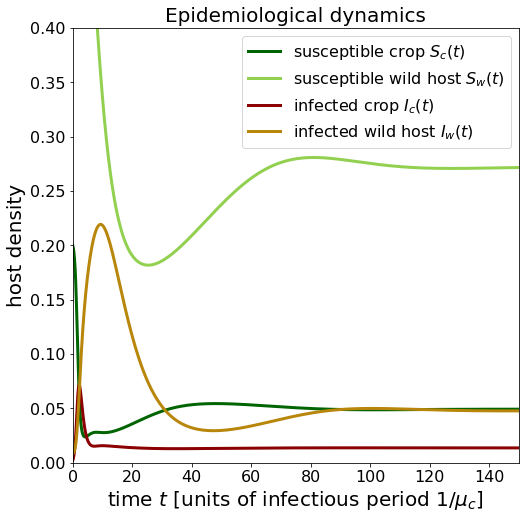

In [12]:
####This code produces Fig 2B.

figwidth_hd = 8
figheight_hd = 8
nt_max = 2000
plt.figure(figsize=(figwidth_hd, figheight_hd))
splt1 = plt.subplot(111)
plt.title("Epidemiological dynamics", fontsize=20)
plt.ylabel("host density", fontsize=20)
plt.xlabel("time $t$ [units of infectious period $1/\\mu_c$]", fontsize=20)
#splt1.xaxis.set_major_locator(MaxNLocator(3))
#splt1.yaxis.set_major_locator(FixedLocator([0.0, 0.5, 1.0]))
for label in splt1.get_xticklabels() + splt1.get_yticklabels():
    label.set_fontsize(16)
splt1.plot(t_ar, Sc_t, color='DarkGreen', lw=lw, label='susceptible crop $S_c(t)$')
# #'#00FF66'
splt1.plot(t_ar, Sw_t, color='#92D050', lw=lw, label='susceptible wild host $S_w(t)$')
splt1.plot(t_ar, Ic_t, color='DarkRed', lw=lw, label='infected crop $I_c(t)$')
splt1.plot(t_ar, Iw_t, color='darkgoldenrod', lw=lw, label='infected wild host $I_w(t)$')
#splt1.axhline(y=Scstar, color='grey', lw=0.5*lw, ls="--")
#splt1.axhline(y=Icstar, color='k', lw=0.5*lw, ls="--")
#splt1.axhline(y=Swstar, color='magenta', lw=0.5*lw, ls="--")
#splt1.axhline(y=Iwstar, color='cyan', lw=0.5*lw, ls="--")
plt.xlim([0.0, 150.0])
plt.ylim([0.0, 0.4])
plt.legend(loc='upper right', prop={"size":16})
mkdirs("./figures/")
plt.savefig("./figures/2_host_dynamics_panelB.svg", format="svg")
plt.show()


In [13]:
pwd

'/home/rigdzin/git_repos/wild_plant_crop_interface_review'

In [14]:
def Lambda_c(gamma_c, kappa_c, nu_c, psi_c, epsilon_c):
    return gamma_c * kappa_c * (nu_c / psi_c)* np.log(1/(1-epsilon_c))

def Lambda_w(gamma_w, eta_w, kappa_w, delta_w):
    return 0.5*gamma_w * kappa_w * (2 - eta_w) * delta_w

def Lambda(gamma_c, kappa_c, nu_c, psi_c, epsilon_c, gamma_w, eta_w, kappa_w, delta_w):
    return Lambda_c(gamma_c, kappa_c, nu_c, psi_c, epsilon_c) + Lambda_w(gamma_w, eta_w, kappa_w, delta_w)


In [15]:
def compute_Lambda_grid(pars, epsilon_range=(0.0001, 0.79999), delta_range=(0.0001, 0.1), resolution=100):
    """
    Computes a grid of Lambda values over epsilon_c and delta_w.

    Parameters:
    - pars (dict): dictionary containing gamma_c, gamma_w, kappa_c, kappa_w, nu_c, psi_c, eta_w
    - epsilon_range (tuple): range of epsilon_c values (default: (0.0001, 0.9999))
    - delta_range (tuple): range of delta_w values (default: (0, 0.04))
    - resolution (int): number of points along each axis (default: 200)

    Returns:
    - E, D (2D arrays): meshgrid arrays of epsilon and delta
    - Lambda_vals (2D array): corresponding grid of Lambda values
    """
    # Grid values
    epsilon_vals = np.linspace(*epsilon_range, resolution)
    delta_vals = np.linspace(*delta_range, resolution)
    E, D = np.meshgrid(epsilon_vals, delta_vals)

    # Compute Lambda values
    Lambda_vals = np.zeros_like(E)

    gamma_c = pars['gamma_c']
    psi_c = pars['psi_c']
    zeta_c = pars['zeta_c']
    nu_c = pars['nu_c']
    tau_c = pars['tau_c']
    phi_c = pars['phi_c']
    
    gamma_w = pars['gamma_w']
    eta_w = pars['eta_w']
    tau_w = pars['tau_w']
    
    kappa_c = pars['kappa_c']
    kappa_w = pars['kappa_w']

    rho_w = pars['rho_w']
    alpha_S = pars['alpha_S']

    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            epsilon_c = E[i, j]
            delta_w = D[i, j]
            ####definitions of Lambda_c and Lambda_w
            #lambda_c = gamma_c * kappa_c * zeta_c * np.log(1 / (1 - epsilon_c/phi_c))
            lambda_c = gamma_c * kappa_c * nu_c/psi_c * np.log(1 / (1 - epsilon_c/phi_c))
            #lambda_w = 0.5 * gamma_w * kappa_w * (2 - eta_w) * delta_w
            lambda_w = gamma_w * kappa_w * delta_w
            Lambda_vals[i, j] = lambda_c + lambda_w
    
    return E, D, Lambda_vals
delta_max = params_eqR0['rho_w']/params_eqR0['alpha_S']
E, D, Lambda_vals_altern = compute_Lambda_grid(params_eqR0, epsilon_range=(0.0001, 0.69), delta_range=(0.001, delta_max), resolution=200)


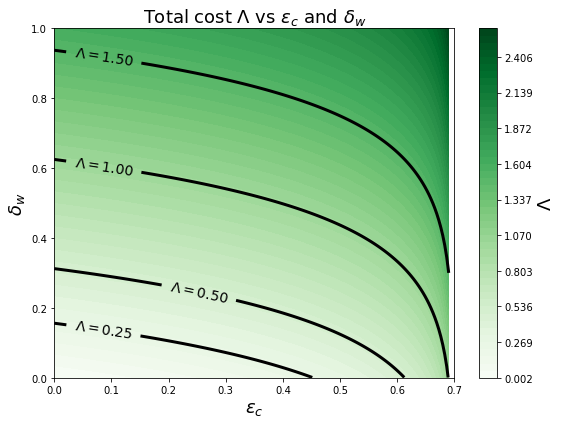

In [16]:
#print("delta_max", delta_max)
# Create the plot
Lambda_list = [0.25, 0.5, 1.0, 1.5]
plt.figure(figsize=(figwidth, figheight))

# Define contour levels for background
levels = np.linspace(np.min(Lambda_vals_altern), np.max(Lambda_vals_altern), 50)

# Filled contour plot
contour = plt.contourf(E, D, Lambda_vals_altern, levels=levels, cmap='Greens')

# Colorbar
cbar = plt.colorbar(contour)
cbar.set_label(r'$\Lambda$', fontsize=fs)

# Add contour line at Lambda = 0.02
contour_line = plt.contour(E, D, Lambda_vals_altern, levels=Lambda_list, colors='black', linewidths=lw)
#plt.clabel(contour_line, fmt=r'$\Lambda=0.02$', inline=True, fontsize=10)
# Label each line with its actual Lambda value using LaTeX formatting
fmt = {level: fr'$\Lambda={level:.2f}$' for level in contour_line.levels}
plt.clabel(contour_line, fmt=fmt, inline=True, fontsize=fs_sm)
plt.xlim([0.0, 0.7])
plt.ylim([0.0, delta_max])

# Axis labels and title
plt.xlabel(r'$\varepsilon_c$', fontsize=fs)
plt.ylabel(r'$\delta_w$', fontsize=fs)
plt.title(r'Total cost $\Lambda$ vs $\varepsilon_c$ and $\delta_w$', fontsize=fs)
#plt.savefig("./figures/Lambda_vs_epsilon_c_and_delta_w.svg", format="svg")
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters
params = params_eqR0.copy()
#Lambda_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
p_vals = np.linspace(0.01, 0.99, 200)

# Store data
R0_curves = {}
p_min_list = []
eps_c_min_list = []
delt_w_min_list = []

# Compute R0 curves for each Lambda level
for Lambda_total in Lambda_list:
    R0_vals = []
    eps_c_vals = []
    delt_w_vals = []

    for p in p_vals:
        # Allocate costs
        Lambda_c_val = p * Lambda_total
        Lambda_w_val = (1 - p) * Lambda_total

        # Solve for epsilon_c from Lambda_c
        A_c = params['gamma_c'] * params['kappa_c'] * (params['nu_c'] / params['psi_c'])
        #epsilon_c = 1 - np.exp(-Lambda_c_val / A_c)
        ###new parameterization includes maximum fungicide effect (dose response curve asymptote )
        epsilon_c = params['phi_c']*(1 - np.exp(-Lambda_c_val / A_c))
        eps_c_vals.append(epsilon_c)

        # Solve for delta_w from Lambda_w
        A_w = params['gamma_w'] * params['kappa_w']
        delta_w = Lambda_w_val / A_w
        delt_w_vals.append(delta_w)
        
        # Compute R0
        R0 = compute_R0_v2(params_dict=params,
            delta_w=delta_w,
            epsilon_c=epsilon_c, rho_w=params['rho_w'])[0]
        R0_vals.append(R0)
    iR0min = np.argmin(R0_vals)
    p_min = p_vals[iR0min]
    eps_c_min = eps_c_vals[iR0min]
    delt_w_min = delt_w_vals[iR0min]
    p_min_list.append(p_min)
    eps_c_min_list.append(eps_c_min)
    delt_w_min_list.append(delt_w_min)
    
    ###here for each of the Lambda values from Lambda list, find the p_min corresp to minimum R0 
    ###and the associated eps_c_m and delt

    R0_curves[Lambda_total] = R0_vals

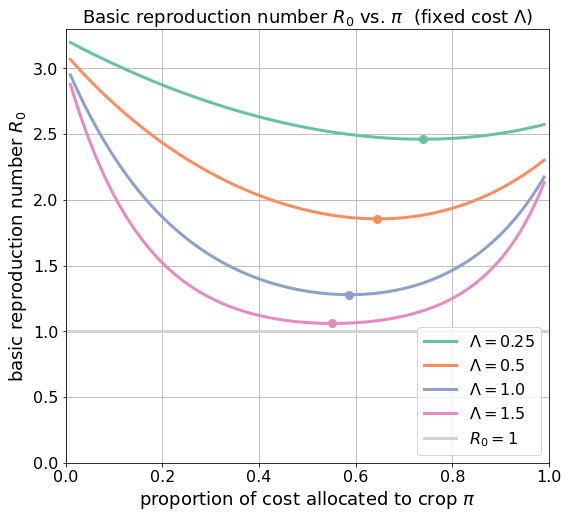

In [18]:
###This code produces Fig 3C.

plt.figure(figsize=(8, 7.3))

# Choose a pastel and colorblind-friendly colormap
cmap = plt.get_cmap('Set2')  # has up to 8 nicely distinguishable pastel colors
colors = [cmap(i) for i in range(len(Lambda_list))]

for i, Lambda_total in enumerate(Lambda_list):
    y_vals = R0_curves[Lambda_total]
    color = colors[i]
    
    # Plot the curve
    plt.plot(p_vals, y_vals, label=fr'$\Lambda = {Lambda_total}$', color=color, lw=lw)
    
    # Find index of the minimum
    idx_min = np.argmin(y_vals)
    x_min = p_vals[idx_min]
    y_min = y_vals[idx_min]
    
    # Add marker at the minimum
    plt.plot(x_min, y_min, marker='o', markersize=8, color=color)

plt.axhline(1.0, color='LightGray', linestyle='-', linewidth=lw, label=r'$R_0 = 1$')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 3.3])

plt.xlabel('proportion of cost allocated to crop $\pi$', fontsize=18)
plt.ylabel(r'basic reproduction number $R_0$', fontsize=18)
plt.title(r'Basic reproduction number $R_0$ vs. $\pi$  (fixed cost $\Lambda$)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.tight_layout()
plt.savefig("./figures/5_R0_vs_pi_panelE.svg", format="svg")
plt.show()

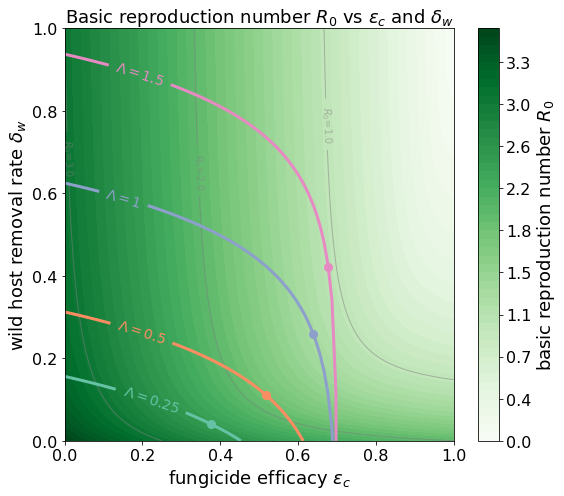

In [19]:
###This code produces Fig 3A

params = params_eqR0.copy()
verbose = False
# Grid of epsilon and delta values
epsilon_vals = np.linspace(0, 1.0, 100)
delta_vals = np.linspace(0, 1.0, 100)
E, D = np.meshgrid(epsilon_vals, delta_vals)

# Compute R0 for each point in the grid
R0_vals = np.zeros_like(E)

for i in range(E.shape[0]):
    for j in range(E.shape[1]):
        R0_vals[i, j] = compute_R0_v2(params_dict=params,
            delta_w=D[i, j], epsilon_c=E[i, j])[0]

# Plotting
fig, ax = plt.subplots(figsize=(8, 7))
levels = np.linspace(np.min(R0_vals), np.max(R0_vals), 50)
contour = ax.contourf(E, D, R0_vals, levels=levels, cmap='Greens')

colbar = plt.colorbar(contour, ax=ax)
colbar.ax.tick_params(labelsize=16)
colbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
colbar.set_label('basic reproduction number $R_0$', fontsize=18)

contours = ax.contour(E, D, R0_vals, levels=[1.0, 2.0, 3.0],
                      colors='Gray', linewidths=1, alpha=0.5)
ax.clabel(contours, fmt='$R_0$=%.1f', inline=True, fontsize=10)

###plot iso cost curves
# ----- Λ on the SAME grid, using your exact formula (vectorized) -----
# numerical safeguard: keep epsilon_c/phi_c strictly < 1 to avoid log(0)
ratio = np.clip(E / params['phi_c'], None, 1 - 1e-12)
lambda_c = params['gamma_c'] * params['kappa_c'] * (params['nu_c'] / params['psi_c']) * np.log(1.0 / (1.0 - ratio))
lambda_w = params['gamma_w'] * params['kappa_w'] * D
Lambda_on_ED = lambda_c + lambda_w

# Optional: report Λ range on this grid
if verbose:
    Lmin, Lmax = np.nanmin(Lambda_on_ED), np.nanmax(Lambda_on_ED)
    print(f"Λ range on grid: [{Lmin:.6g}, {Lmax:.6g}]")

# Keep only Λ levels that actually fall inside the computed range
Lmin, Lmax = np.nanmin(Lambda_on_ED), np.nanmax(Lambda_on_ED)
levels_in_range = [L for L in Lambda_list if (Lmin <= L <= Lmax)]
if verbose:
    print(f"Requested Λ levels: {Lambda_list}\nUsing Λ levels: {levels_in_range}")

# ----- Overlay Λ iso-cost contour lines -----
if levels_in_range:
    cmap_set2 = plt.get_cmap('Set2')
    colors = [cmap_set2(i) for i in range(len(levels_in_range))]
    cs_lam = plt.contour(E, D, Lambda_on_ED,
                         levels=levels_in_range,
                         colors=colors, linewidths=lw)
    fmt = {lvl: rf'$\Lambda={lvl:.3g}$' for lvl in cs_lam.levels}
    plt.clabel(cs_lam, fmt=fmt, inline=True, fontsize=fs_sm)

for ind, Lambda in enumerate(Lambda_list):
    #eps_c_min_list.append(eps_c_min)
    #delt_w_min_list.append(delt_w_min)
    eps_c_min = eps_c_min_list[ind]
    delt_w_min = delt_w_min_list[ind]
    plt.plot(eps_c_min, delt_w_min, marker='o', markersize=8, color=colors[ind])
    
ax.set_xlabel('fungicide efficacy $\\varepsilon_c$', fontsize=18)
ax.set_ylabel('wild host removal rate $\\delta_w$', fontsize=18)
ax.set_title('Basic reproduction number $R_0$ vs $\\varepsilon_c$ and $\\delta_w$', fontsize=18)

# Set tick label font size
ax.tick_params(axis='both', which='major', labelsize=16)

plt.xlim([0.0, 1.0])
plt.tight_layout()
plt.savefig("./figures/3_R0_vs_epsilon_c_and_delta_w_panelC.svg", format="svg")
plt.show()


In [20]:
def compute_yield(Sc_t, Sw_t, chi_c, chi_w, decompose=False):
    """
    Computes the rate at which the monetary value of yield accrues, Y, given an array of S_c(t) and S_w(t) values,
    chi_c and chi_w are the weights representing the value of the crop and wild.

    Parameters:
    - S_c_array (np.ndarray): array of S_c(t) values over time
    - S_w_array
    - chi_c (float): weight of crop
    - chi_w (float): weight of crop

    Returns:
    - Y (float): the rate at which the monetary value of yield accrues
    """
    # Assume uniform time steps
    if decompose:
        return chi_c * Sc_t[-1], chi_w * Sw_t[-1], chi_c * Sc_t[-1] + chi_w * Sw_t[-1]
    else:
        return chi_c * Sc_t[-1] + chi_w * Sw_t[-1]

In [21]:
def simulate_state_vars_yield(pars, model, decompose_yield=False, **kwargs):
    """
    Simulates the crop-wild system and returns the yield Y.
    Allows overriding values in the parameter dictionary via keyword arguments.

    Parameters:
    - pars (dict): dictionary containing all model parameters, including:
        - 'rho_c', 'rho_w', 'kappa_c', 'kappa_w',
        - 'sigma_c', 'sigma_w', 'omega_c', 'omega_w',
        - 'mu_c', 'mu_w', 'theta_c', 'theta_w',
        - 'delta', 'epsilon', 'alpha_y', 'tmax', 'dt'
    - kwargs: optional overrides of specific parameters (e.g. delta=0.01)

    Returns:
    - Y (float): average yield over time
    """
    # Merge overrides into the parameter dictionary
    full_pars = pars.copy()
    full_pars.update(kwargs)

    # Extract simulation parameters
    tmax = full_pars['tmax']
    dt = full_pars['dt']

    # Initial conditions
    Sc0 = 1.0 * full_pars['kappa_c']
    Ic0 = 0.01 * full_pars['kappa_c']
    Sw0 = 1.0 * full_pars['kappa_w']
    Iw0 = 0.01 * full_pars['kappa_w']
    ic = np.array([Sc0, Ic0, Sw0, Iw0], dtype='d')

    model_pars = full_pars #{key: full_pars[key] for key in param_keys}

    # Build and solve the model
    model = model(ic=ic, pars=model_pars)
    solver = DetSolver(model, tbeg=0.0, tend=tmax, dt=dt)
    _, pops = solver.propagate()

    # Extract Sc(t) and compute yield
    Sc_t = pops[:, 0]
    Ic_t = pops[:, 1]
    Sw_t = pops[:, 2]
    Iw_t = pops[:, 3]
    Yc, Yw, Y= compute_yield(Sc_t, Sw_t, model_pars['chi_c'], model_pars['chi_w'], decompose=True)
    if decompose_yield:
        return Sc_t[-1], Ic_t[-1], Sw_t[-1], Iw_t[-1], Yc, Yw, Y
    else:
        return Sc_t[-1], Ic_t[-1], Sw_t[-1], Iw_t[-1], Y

In [22]:
def compute_yield_surface(params, Lambda_total, resolution=100):
    """
    Computes yield over a grid of epsilon_c and delta_w for a fixed Lambda_total.

    Parameters:
    - params (dict): parameter dictionary
    - Lambda_total (float): total control budget Lambda = Lambda_c + Lambda_w
    - resolution (int): number of points along each axis

    Returns:
    - E, D (2D arrays): meshgrid of epsilon_c and delta_w
    - Y_vals (2D array): simulated yield at each point
    """
    p_vals = np.linspace(0.01, 0.99, resolution)
    epsilon_c_vals = []
    delta_w_vals = []

    A_c = params['gamma_c'] * params['kappa_c'] * (params['nu_c'] / params['psi_c'])
    A_w = params['gamma_w'] * params['kappa_w']
    phi_c = params['phi_c']

    for p in p_vals:
        Lambda_c_val = p * Lambda_total
        Lambda_w_val = (1 - p) * Lambda_total

        epsilon_c = phi_c * (1 - np.exp(-Lambda_c_val / A_c))
        delta_w = Lambda_w_val / A_w

        epsilon_c_vals.append(epsilon_c)
        delta_w_vals.append(delta_w)

    E, D = np.meshgrid(epsilon_c_vals, delta_w_vals)
    Y_vals = np.zeros_like(E)

    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            eps = E[i, j]
            delt = D[i, j]
            _, _, _, _, Y = simulate_state_vars_yield(params, epsilon_c=eps, delta_w=delt)
            Y_vals[i, j] = Y

    return E, D, Y_vals

In [23]:
def compute_yield_surface_parallel(params, model, epsilon_c_vals, delta_w_vals, n_jobs=-1):
    """
    Parallel version to compute yield over a grid of epsilon_c and delta_w for fixed Lambda_total.

    Parameters:
    - params (dict): model parameters
    - Lambda_total (float): total cost budget Lambda = Lambda_c + Lambda_w
    - resolution (int): grid resolution
    - n_jobs (int): number of parallel workers (-1 = use all CPUs)

    Returns:
    - E, D (2D arrays): meshgrids of epsilon and delta
    - Y_vals (2D array): yield values at each grid point
    """
    from joblib import Parallel, delayed
    # Create meshgrid
    E, D = np.meshgrid(epsilon_c_vals, delta_w_vals)
    points = list(zip(E.ravel(), D.ravel()))

    # Parallelized simulation
    def evaluate_point(eps, delt):
        _, _, _, _, Y = simulate_state_vars_yield(params, model, epsilon_c=eps, delta_w=delt)
        return Y

    Y_flat = Parallel(n_jobs=n_jobs)(delayed(evaluate_point)(eps, delt) for eps, delt in points)
    Y_vals = np.reshape(Y_flat, E.shape)

    return E, D, Y_vals

def plot_yield_surface_old(E, D, Y_vals):
    plt.figure(figsize=(figwidth, figheight))
    cp = plt.contourf(E, D, Y_vals, levels=30, cmap='viridis')
    plt.colorbar(cp, label='yield $Y$', ticks=[1.0, 1.5, 2.0, 2.5, 3.0])
    plt.xlabel(r'$\varepsilon_c$ (fungicide efficacy)', fontsize=fs)
    plt.ylabel(r'$\delta_w$ (removal rate of wild hosts)', fontsize=fs)
    plt.title(rf'Yield $Y$ vs. $\epsilon_c$ and $\delta_w$')
    plt.savefig("./figures/4_yield_epsilon_c_delat_w_panelD.svg", format="svg")
    plt.tight_layout()
    plt.show()

def plot_yield_surface(E, D, Y_vals, Lambda_list, params):
    plt.figure(figsize=(figwidth, figheight))

    # --- Yield surface ---
    cp = plt.contourf(E, D, Y_vals, levels=30, cmap='viridis')
    cbar = plt.colorbar(cp)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    cbar.set_label('yield $Y$', fontsize=18)

    # --- Compute Λ on the SAME grid as (E, D) to avoid shape mismatch ---
    Lambda_on_ED = Lambda(
        params['gamma_c'], params['kappa_c'], params['nu_c'], params['psi_c'], E,
        params['gamma_w'], params['eta_w'], params['kappa_w'], D
    )

    # --- Λ iso-cost lines (use Set2 colors) ---
    cmap_set2 = plt.get_cmap('Set2')
    colors = [cmap_set2(i) for i in range(len(Lambda_list))]

    cs_lam = plt.contour(
        E, D, Lambda_on_ED,
        levels=Lambda_list,
        colors=colors,
        linewidths=2.0
    )
    fmt = {lvl: rf'$\Lambda={lvl:.3g}$' for lvl in cs_lam.levels}
    plt.clabel(cs_lam, fmt=fmt, inline=True, fontsize=10)

    # --- Labels & layout ---
    plt.xlabel(r'$\varepsilon_c$ (fungicide efficacy)', fontsize=fs)
    plt.ylabel(r'$\delta_w$ (removal rate of wild hosts)', fontsize=fs)
    plt.title(r'Yield $Y$ vs. $\epsilon_c$ and $\delta_w$', fontsize=fs)
    plt.tight_layout()
    plt.savefig("./figures/4_yield_epsilon_c_delat_w_panelD.svg", format="svg")
    plt.show()


In [24]:
params = params_eqR0.copy()
ng = 100
#epsilon_c_vals = np.linspace(0.01, params['phi_c'], ng)
epsilon_c_vals = np.linspace(0.0, 1.0, ng)
delta_w_vals = np.linspace(0.0, delta_max, ng)

#E, D, Y_vals = compute_yield_surface_parallel(params, crop_wild_1path_Model5, epsilon_c_vals, delta_w_vals, n_jobs=-1)
E, D, Y_surface = compute_yield_surface_parallel(params_eqR0, crop_wild_1path_Model5, epsilon_c_vals, delta_w_vals, n_jobs=-1)



In [25]:
from joblib import Parallel, delayed

def compute_yield_curves_parallel(Lambda_levels, params, model, p_vals=np.linspace(0.01, 0.99, 60), n_jobs=-1, decompose_yield=False):
    """
    Computes yield and state variables across Lambda_levels and p values using parallel processing.

    Parameters:
    - Lambda_levels (list): total control budgets Lambda to explore
    - params (dict): parameter dictionary
    - p_vals (array-like): values of p (proportion of cost allocated to crops)
    - n_jobs (int): number of CPU cores to use (-1 = all available)

    Returns:
    - dicts: Y_curves, Sc_curves, Ic_curves, Sw_curves, Iw_curves, epsilon_c_curves, delta_w_curves
    """

    # Initialize output dictionaries
    Yc_curves = {}
    Yw_curves = {}
    Y_curves = {}
    Sc_curves = {}
    Ic_curves = {}
    Sw_curves = {}
    Iw_curves = {}
    epsilon_c_curves = {}
    delta_w_curves = {}

    # Precompute constants
    A_c = params['gamma_c'] * params['kappa_c'] * (params['nu_c'] / params['psi_c'])
    A_w = params['gamma_w'] * params['kappa_w']
    phi_c = params['phi_c']

    for Lambda_total in Lambda_levels:

        def simulate_for_p(p):
            Lambda_c_val = p * Lambda_total
            Lambda_w_val = (1 - p) * Lambda_total

            epsilon_c = phi_c * (1 - np.exp(-Lambda_c_val / A_c))
            delta_w = Lambda_w_val / A_w
            Sc, Ic, Sw, Iw, Yc, Yw, Y = simulate_state_vars_yield(params, model, epsilon_c=epsilon_c, delta_w=delta_w, decompose_yield=True)
            if decompose_yield:
                return Sc, Ic, Sw, Iw, Yc, Yw, Y, epsilon_c, delta_w
            else:
                return Sc, Ic, Sw, Iw, Y, epsilon_c, delta_w

        # Parallel simulation
        results = Parallel(n_jobs=n_jobs)(delayed(simulate_for_p)(p) for p in p_vals)

        # Unpack results
        if decompose_yield:
            Sc_vals, Ic_vals, Sw_vals, Iw_vals, Yc_vals, Yw_vals, Y_vals, epsilon_c_vals, delta_w_vals = zip(*results)
        else:
            Sc_vals, Ic_vals, Sw_vals, Iw_vals, Y_vals, epsilon_c_vals, delta_w_vals = zip(*results)
        

        # Store in dicts
        Y_curves[Lambda_total] = list(Y_vals)
        if decompose_yield:
            Yc_curves[Lambda_total] = list(Yc_vals)
            Yw_curves[Lambda_total] = list(Yw_vals)
        Sc_curves[Lambda_total] = list(Sc_vals)
        Ic_curves[Lambda_total] = list(Ic_vals)
        Sw_curves[Lambda_total] = list(Sw_vals)
        Iw_curves[Lambda_total] = list(Iw_vals)
        epsilon_c_curves[Lambda_total] = list(epsilon_c_vals)
        delta_w_curves[Lambda_total] = list(delta_w_vals)
    if decompose_yield:
        return (Yc_curves, Yw_curves, Y_curves, Sc_curves, Ic_curves, Sw_curves, Iw_curves,
                epsilon_c_curves, delta_w_curves)
    else:
        return (Y_curves, Sc_curves, Ic_curves, Sw_curves, Iw_curves,
                epsilon_c_curves, delta_w_curves)

In [26]:
params = params_eqR0.copy()
p_vals=np.linspace(0.0, 1.0, 60)

Y_curves, Sc_curves, Ic_curves, Sw_curves, Iw_curves, \
epsilon_c_curves, delta_w_curves = compute_yield_curves_parallel(Lambda_list, params, crop_wild_1path_Model5, p_vals=p_vals)

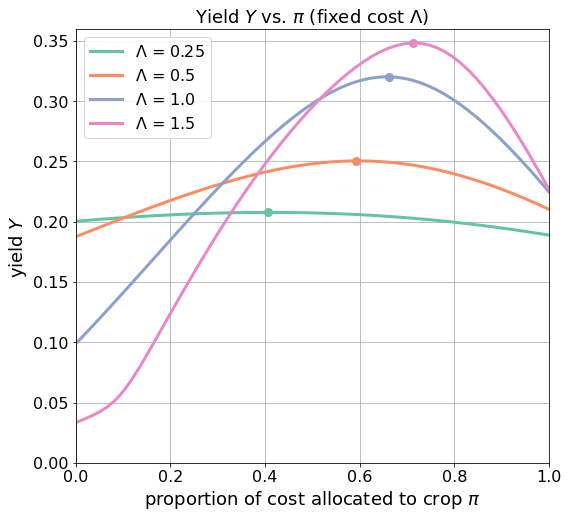

In [27]:
###This code produces Fig 3D.

# -------------------- Plot Y vs p --------------------
plt.figure(figsize=(8, 7.3))
eps_c_max_list = []
delta_w_max_list = []
for i, (Lambda_total, Y_vals) in enumerate(Y_curves.items()):
    color = colors[i]
    # plot the curve
    plt.plot(p_vals, Y_vals, label=f"$\\Lambda$ = {Lambda_total}", lw=lw, color=color)
    
    # find index of maximum
    idx_max = np.argmax(Y_vals)
    p_max = p_vals[idx_max]
    y_max = Y_vals[idx_max]
    
    eps_c_ar = epsilon_c_curves[Lambda_total]
    delta_w_ar = delta_w_curves[Lambda_total]
    eps_c_max = eps_c_ar[idx_max]
    delta_w_max = delta_w_ar[idx_max]
    eps_c_max_list.append(eps_c_max)
    delta_w_max_list.append(delta_w_max)
    
    # add marker at maximum
    plt.plot(p_max, y_max, marker='o', markersize=8, color=color)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.36])

plt.xlabel("proportion of cost allocated to crop $\pi$", fontsize=18)
plt.ylabel("yield $Y$", fontsize=18)
plt.title("Yield $Y$ vs. $\pi$ (fixed cost $\\Lambda$)", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/6_Lambda_vs_pi_panelF.svg", format="svg")
plt.show()



Λ range on grid: [0, 8.23145]
Requested Λ levels: [0.25, 0.5, 1.0, 1.5]
Using Λ levels: [0.25, 0.5, 1.0, 1.5]


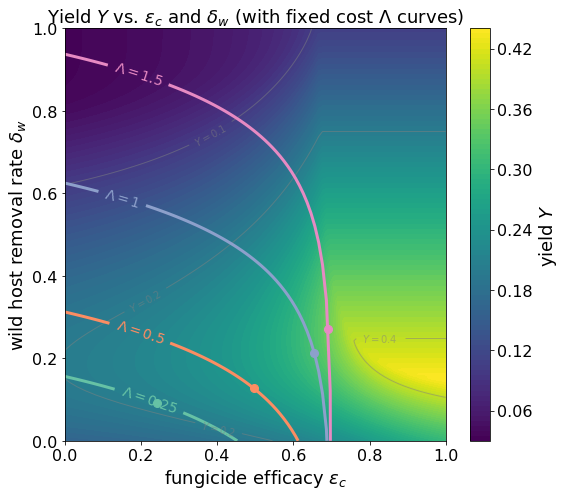

In [28]:
###This code produces Fig 3B.

def plot_yield_surface_debug(E, D, Y_surface, Lambda_list, params, delta_max=None, show_analytic=False, verbose=False):
    import numpy as np
    import matplotlib.pyplot as plt

    # ----- Inputs as arrays -----
    E = np.asarray(E)  # epsilon_c grid (2D)
    D = np.asarray(D)  # delta_w grid (2D)
    Y = np.asarray(Y_surface)

    if not (E.ndim == D.ndim == Y.ndim == 2 and E.shape == D.shape == Y.shape):
        raise ValueError(f"E, D, Y_surface must be 2D with identical shapes; got {E.shape}, {D.shape}, {Y.shape}")

    # ----- Unpack params used by your Lambda formula -----
    gamma_c = params['gamma_c']
    kappa_c = params['kappa_c']
    nu_c    = params['nu_c']
    psi_c   = params['psi_c']
    phi_c   = params['phi_c']
    gamma_w = params['gamma_w']
    kappa_w = params['kappa_w']

    # ----- Figure: yield surface -----
    plt.figure(figsize=(8, 7))
    cp = plt.contourf(E, D, Y, levels=ng, cmap='viridis')
    cbar = plt.colorbar(cp)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    cbar.locator = MaxNLocator(nbins=7)   # request ~5 ticks (between 4–6)
    cbar.update_ticks()   
    cbar.set_label('yield $Y$', fontsize=18)

    # ----- Λ on the SAME grid, using your exact formula (vectorized) -----
    # numerical safeguard: keep epsilon_c/phi_c strictly < 1 to avoid log(0)
    ratio = np.clip(E / phi_c, None, 1 - 1e-12)
    lambda_c = gamma_c * kappa_c * (nu_c / psi_c) * np.log(1.0 / (1.0 - ratio))
    lambda_w = gamma_w * kappa_w * D
    Lambda_on_ED = lambda_c + lambda_w

    # Optional: report Λ range on this grid
    if verbose:
        Lmin, Lmax = np.nanmin(Lambda_on_ED), np.nanmax(Lambda_on_ED)
        print(f"Λ range on grid: [{Lmin:.6g}, {Lmax:.6g}]")

    # Keep only Λ levels that actually fall inside the computed range
    Lmin, Lmax = np.nanmin(Lambda_on_ED), np.nanmax(Lambda_on_ED)
    levels_in_range = [L for L in Lambda_list if (Lmin <= L <= Lmax)]
    if verbose:
        print(f"Requested Λ levels: {Lambda_list}\nUsing Λ levels: {levels_in_range}")
        
    # ----- Overlay Y iso-yield contour lines at 0.1, 0.2, 0.4 -----
    lw_iso = 1.0
    fs_iso = 10
    y_levels_req = [0.1, 0.2, 0.4]
    Ymin, Ymax = np.nanmin(Y), np.nanmax(Y)
    y_levels_in_range = [y for y in y_levels_req if (Ymin <= y <= Ymax)]

    if y_levels_in_range:
        # Use a distinct style from Λ curves so both are readable
        cs_y = plt.contour(
            E, D, Y,
            levels=y_levels_in_range,
            colors='Gray',              # white lines over viridis background
            linewidths=lw_iso,
            linestyles='solid', alpha=0.5
        )
        yfmt = {lvl: rf'$Y={lvl:.3g}$' for lvl in cs_y.levels}
        plt.clabel(cs_y, fmt=yfmt, inline=True, fontsize=fs_iso)
        
        
    # ----- Overlay Λ iso-cost contour lines -----
    if levels_in_range:
        cmap_set2 = plt.get_cmap('Set2')
        colors = [cmap_set2(i) for i in range(len(levels_in_range))]
        cs_lam = plt.contour(E, D, Lambda_on_ED,
                             levels=levels_in_range,
                             colors=colors, linewidths=lw)
        fmt = {lvl: rf'$\Lambda={lvl:.3g}$' for lvl in cs_lam.levels}
        plt.clabel(cs_lam, fmt=fmt, inline=True, fontsize=fs_sm)
        
        #lvl = cs_lam.levels[0]   # choose the one you want
        #plt.clabel(cs_lam, fmt=fmt, levels=[lvl], manual=[(0.2, 0.2)], inline=True, fontsize=fs_sm)


        # ----- Optional: analytic Λ curves δ(ε|Λ) for a sanity-check (dashed) -----
        if show_analytic:
            A = gamma_c * kappa_c * (nu_c / psi_c)
            C = gamma_w * kappa_w
            eps_min = float(np.nanmin(E))
            eps_max = float(min(np.nanmax(E), 0.999999 * phi_c))  # must be < phi_c
            eps_lin = np.linspace(eps_min, eps_max, 800)

            # δ(ε|Λ) = (Λ - A * ln(1/(1 - ε/φ_c))) / C
            for i, L in enumerate(levels_in_range):
                delta_line = (L - A * np.log(1.0 / (1.0 - np.clip(eps_lin / phi_c, None, 1 - 1e-12)))) / C
                valid = (delta_line >= 0)
                ymax = float(np.nanmax(D)) if delta_max is None else float(delta_max)
                valid &= (delta_line <= ymax)
                plt.plot(eps_lin[valid], delta_line[valid],
                         linestyle='--', linewidth=1.2, color=colors[i], alpha=0.9, label="$\Lambda=%s$" % L)

                # mark where δ = 0: ε* = φ_c * (1 - exp(-Λ/A))
                eps_star = phi_c * (1.0 - np.exp(-L / A))
                if eps_min <= eps_star <= eps_max:
                    plt.plot([eps_star], [0.0], marker='o', ms=4, color=colors[i])

###Y_curves, Sc_curves, Ic_curves, Sw_curves, Iw_curves, \
###epsilon_c_curves, delta_w_curves
    for ind, Lambda in enumerate(Lambda_list):
        #eps_c_min_list.append(eps_c_min)
        #delt_w_min_list.append(delt_w_min)
        eps_c_max = eps_c_max_list[ind]
        delta_w_max = delta_w_max_list[ind]
        plt.plot(eps_c_max, delta_w_max, marker='o', markersize=8, color=colors[ind])
                    
                    
    # ----- Labels / layout -----
    plt.xlabel(r'fungicide efficacy $\varepsilon_c$', fontsize=18)
    plt.ylabel(r'wild host removal rate $\delta_w$', fontsize=18)
    plt.title(r'Yield $Y$ vs. $\epsilon_c$ and $\delta_w$ (with fixed cost $\Lambda$ curves)', fontsize=18)
#    plt.legend(loc='upper right', prop={"size":18})
    # Set tick label font size
    plt.tick_params(axis='both', which='major', labelsize=16)
    if delta_max is not None:
        plt.ylim(0, delta_max)
    plt.tight_layout()
    plt.savefig("./figures/4_yield_epsilon_c_delat_w_panelD.svg", format="svg")
    plt.show()
from matplotlib.ticker import MaxNLocator
plot_yield_surface_debug(E, D, Y_surface, Lambda_list, params_eqR0, verbose=True)

In [29]:
###This code brings the panels A, B, C and D together to produce the entire Fig 3.

import os
from io import BytesIO
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---------------- Publication settings ----------------
# Typical two-column journal width ~6.5 in
PRINT_WIDTH_IN = 6.5
PANEL_H_IN     = 3.0        # height per row (inches)
TARGET_DPI     = 600        # effective DPI for embedded rasters

# Keep text as selectable fonts (TrueType)
mpl.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
})

# ---------------- Helper: load image to target pixels ----------------
def load_image_to_size(path, target_w_px, target_h_px):
    """
    Load image at (approximately) the desired pixel size.
    - PNG/JPG: open then resize to requested pixels (LANCZOS).
    - SVG: render to PNG at requested pixels with cairosvg for sharpness.
    """
    ext = os.path.splitext(path)[1].lower()
    if ext == ".svg":
        try:
            import cairosvg
        except ImportError as e:
            raise ImportError(
                "SVG support requires cairosvg. Install with:\n  pip install cairosvg"
            ) from e
        png_bytes = cairosvg.svg2png(url=path,
                                     output_width=int(target_w_px),
                                     output_height=int(target_h_px))
        img = Image.open(BytesIO(png_bytes)).convert("RGBA")
        return img
    else:
        img = Image.open(path).convert("RGBA")
        if img.width != target_w_px or img.height != target_h_px:
            img = img.resize((int(target_w_px), int(target_h_px)), Image.LANCZOS)
        return img

# ---------------- Inputs ----------------
fig_dir = "./figures"
files = [
    "1_WildCropModel_panelA.png",                      # index 0
    "2_host_dynamics_panelB.svg",                      # index 1
    "3_R0_vs_epsilon_c_and_delta_w_panelC.svg",        # index 2
    "4_yield_epsilon_c_delat_w_panelD.svg",            # index 3
    "5_R0_vs_pi_panelE.svg",                           # index 4
    "6_Lambda_vs_pi_panelF.svg",                       # index 5
]
paths = [os.path.join(fig_dir, f) for f in files]

# ---------------- Figure builder ----------------
def build_mosaic_figure(
    panel_indices,                # list of indices into `paths`
    out_name,                     # output PDF name
    relabels,                     # list of panel labels to draw, same length as panel_indices
    nrows, ncols,                 # grid layout
):
    assert len(panel_indices) == len(relabels) == nrows * ncols, \
        "Number of panels must match grid cells and relabels."

    # Size and pixel targets for this figure
    panel_w_in = PRINT_WIDTH_IN / ncols
    panel_h_in = PANEL_H_IN
    fig_w_in   = PRINT_WIDTH_IN
    fig_h_in   = nrows * panel_h_in

    panel_w_px = int(round(panel_w_in * TARGET_DPI))
    panel_h_px = int(round(panel_h_in * TARGET_DPI))

    fig = plt.figure(figsize=(fig_w_in, fig_h_in))
    grid = ImageGrid(
        fig, 111,
        nrows_ncols=(nrows, ncols),
        axes_pad=0.0,
        share_all=True
    )

        # Populate grid
    for ax, idx, label in zip(grid, panel_indices, relabels):
        p = paths[idx]
        img = load_image_to_size(p, panel_w_px, panel_h_px)

        # Special casing: original panel A (index 0) used an inset to remove padding.
        if idx == 0:
            iax = inset_axes(ax, width="100%", height="100%", loc="center", borderpad=0)
            iax.imshow(img, interpolation="none")
            ax.set_aspect("equal")
            iax.axis("off")
            iax.text(0.0, 0.99, f"({label})", transform=iax.transAxes,
                     va="top", ha="left", fontsize=12, fontweight="bold",
                     bbox=dict(boxstyle="round,pad=0.2", facecolor="white",
                               alpha=0.6, linewidth=0))
            ax.set_visible(False)

        # Special case: panel B (index 1) → scale up by ~10%
        elif idx == 1:
            iax = inset_axes(ax, width="110%", height="110%", loc="center", borderpad=0)
            iax.imshow(img, interpolation="none")
            iax.axis("off")
            iax.text(0.0, 0.95, f"({label})", transform=iax.transAxes,
                     va="top", ha="left", fontsize=12, fontweight="bold",
                     bbox=dict(boxstyle="round,pad=0.2", facecolor="white",
                               alpha=0.6, linewidth=0))
            ax.set_visible(False)

        else:
            ax.imshow(img, interpolation="none")
            ax.set_aspect("equal")   # avoid distortion
            ax.axis("off")
            ax.text(0.0, 0.99, f"({label})", transform=ax.transAxes,
                    va="top", ha="left", fontsize=12, fontweight="bold",
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white",
                              alpha=0.6, linewidth=0))

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    fig.savefig(out_name+'.pdf', format="pdf", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    print(
        f"Saved: {out_name}\n"
        f"Figure size: {fig_w_in:.2f}×{fig_h_in:.2f} in; "
        f"Panel pixels: {panel_w_px}×{panel_h_px} (~{TARGET_DPI} DPI)"
    )

# ---------------- Build the two figures ----------------
# Figure 1: first row → panels A, B (keep labels A, B)
build_mosaic_figure(
    panel_indices=[0, 1],
    out_name="./figures/Fig2",
    relabels=["A", "B"],
    nrows=1, ncols=2
)

# Figure 2: rows 2–3 → original panels C, D, E, F; relabel as A, B, C, D
build_mosaic_figure(
    panel_indices=[2, 3, 4, 5],
    out_name="./figures/Fig3",
    relabels=["A", "B", "C", "D"],
    nrows=2, ncols=2
)


Saved: ./figures/Fig2
Figure size: 6.50×3.00 in; Panel pixels: 1950×1800 (~600 DPI)
Saved: ./figures/Fig3
Figure size: 6.50×6.00 in; Panel pixels: 1950×1800 (~600 DPI)


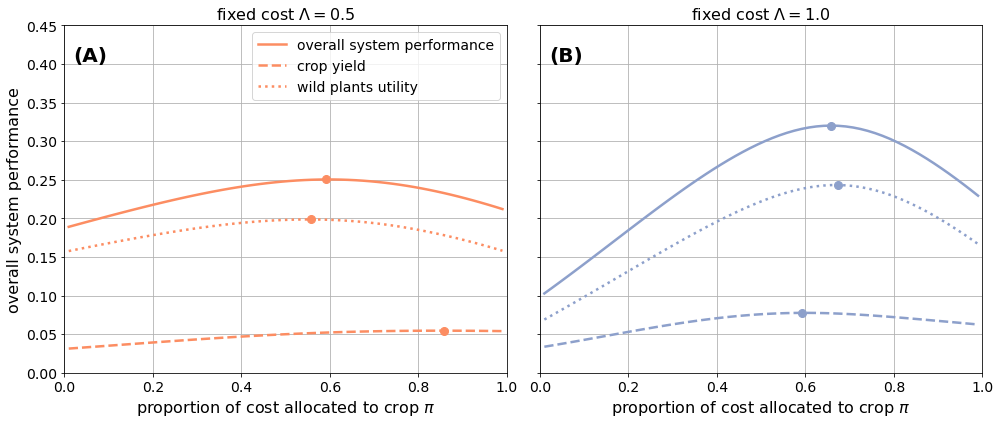

In [30]:
###This code produces Fig S1 for the Supplement

import numpy as np
import matplotlib.pyplot as plt

# --- Setup ---
Lambda_list = [0.5, 1.0]   # two panels: left = 1.0, right = 0.5
p_vals = np.linspace(0.01, 0.99, 60)
params_base = params_eqR0.copy()
params_base.update(c=1)
colors = plt.get_cmap("Set2").colors
lw = 2.5

# --- Create Figure with Two Panels ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for ax_i, Lambda_total in enumerate(Lambda_list):
    # --- Model with connectivity c = 1 ---
    params = params_base.copy()
    params.update(c=1)
    Yc_curves_1, Yw_curves_1, Y_curves_1, *_ = compute_yield_curves_parallel(
        [Lambda_total], params, crop_wild_1path_Model5, p_vals=p_vals, decompose_yield=True
    )

    # --- Model with connectivity c = 0 (if needed) ---
    params_mod = params.copy()
    params_mod.update(c=0)
    Yc_curves_2, Yw_curves_2, Y_curves_2, *_ = compute_yield_curves_parallel(
        [Lambda_total], params_mod, crop_wild_1path_Model5, p_vals=p_vals, decompose_yield=True
    )

    # --- Plot for this Λ ---
    ax = axes[ax_i]
    ax.plot(p_vals, Y_curves_1[Lambda_total], label="overall system performance",
            lw=lw, color=colors[ax_i+1])
    ax.plot(p_vals, Yc_curves_1[Lambda_total], label="crop yield", ls='--',
            lw=lw, color=colors[ax_i+1])
    ax.plot(p_vals, Yw_curves_1[Lambda_total], label="wild plants utility", ls=':',
            lw=lw, color=colors[ax_i+1])

    # --- Maxima markers ---
    Y_vals = Y_curves_1[Lambda_total]
    Yc_vals = Yc_curves_1[Lambda_total]
    Yw_vals = Yw_curves_1[Lambda_total]

    for vals in [Y_vals, Yc_vals, Yw_vals]:
        idx_max = np.argmax(vals)
        ax.plot(p_vals[idx_max], vals[idx_max], 'o', ms=8, color=colors[ax_i+1])

    # --- Axes and labels ---
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 0.45)
    ax.set_xlabel("proportion of cost allocated to crop $\pi$", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True)

    # --- Panel label (A/B) ---
    panel_label = f"({'A' if ax_i == 0 else 'B'})"
    ax.text(0.02, 0.94, panel_label, transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='left')

    # --- Title for panel ---
    ax.set_title(f"fixed cost $\\Lambda={Lambda_total}$", fontsize=16)

# --- Common y-label and legend ---
axes[0].set_ylabel("overall system performance", fontsize=16)
axes[0].legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.savefig("./figures/FigS1_SystPerf_decomp_twopanel.svg", format="svg")
plt.savefig("./figures/FigS1_SystPerf_decomp_twopanel.pdf", format="pdf")
plt.show()


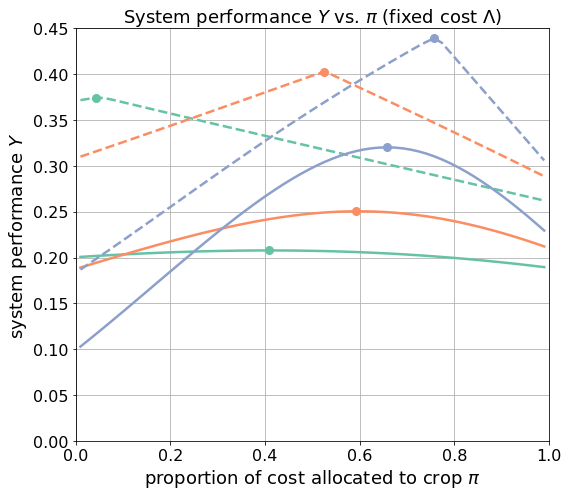

In [31]:
####now, compute the yield curves in the case when at several different values of c in class class crop_wild_1path_Model1
Lambda_list_short = [0.25, 0.5, 1.0]
# Setup
params = params_eqR0.copy()
p_vals = np.linspace(0.01, 0.99, 60)
params.update(c=1)
colors = plt.get_cmap("Set2").colors  # use pastel, colorblind-friendly palette

# ---------- First Model ----------
Y_curves_1, _, _, _, _, _, _ = compute_yield_curves_parallel(
    Lambda_list_short, params, crop_wild_1path_Model5, p_vals=p_vals
)

# ---------- Second Model ----------
params_modified = params.copy()
params_modified.update(c=0)

Y_curves_2, _, _, _, _, _, _ = compute_yield_curves_parallel(
    Lambda_list_short, params_modified, crop_wild_1path_Model5, p_vals=p_vals
)

# ---------- Combined Plot ----------
plt.figure(figsize=(8, 7))

for i, Lambda_total in enumerate(Lambda_list_short):
    # Solid line: first model
    plt.plot(p_vals, Y_curves_1[Lambda_total], label=f"$\\Lambda$ = {Lambda_total:.2f}", 
             lw=lw, color=colors[i])

    # Dashed line: second model
    plt.plot(p_vals, Y_curves_2[Lambda_total], linestyle='--', lw=lw, color=colors[i])

    Y_vals1 = Y_curves_1[Lambda_total]
    Y_vals2 = Y_curves_2[Lambda_total]
 # find index of maximum
    idx_max1 = np.argmax(Y_vals1)
    p_max1 = p_vals[idx_max1]
    y_max1 = Y_vals1[idx_max1]
    
    idx_max2 = np.argmax(Y_vals2)
    p_max2 = p_vals[idx_max2]
    y_max2 = Y_vals2[idx_max2]
    
    # add marker at maximum
    plt.plot(p_max1, y_max1, marker='o', markersize=8, color=colors[i])
    plt.plot(p_max2, y_max2, marker='o', markersize=8, color=colors[i])
    
#plt.ylim([0.0, 1.0])
plt.xlabel("proportion of cost allocated to crop $\pi$", fontsize=18)
plt.ylabel("system performance $Y$", fontsize=18)
plt.title("System performance $Y$ vs. $\pi$ (fixed cost $\\Lambda$)", fontsize=18)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.45])


# Add legend for solid and dashed styles
#from matplotlib.lines import Line2D
#legend_lines = [
#    Line2D([0], [0], color='black', lw=lw, linestyle='-', label='$\lambda=1$'),
#    Line2D([0], [0], color='black', lw=lw, linestyle='--', label='$\lambda=0$')
#]
#legend = plt.legend(handles=legend_lines, title='crop-wild connectivity', loc="lower left", frameon=True, fontsize=16)
#plt.setp(legend.get_title(), fontsize=16)

# Add Lambda-specific legend as annotations
#for i, Lambda_total in enumerate(Lambda_list):
#    pass
    #plt.text(0.65, Y_curves_1[Lambda_total][-1], f"$\\Lambda={Lambda_total:.2f}$",
    #         fontsize=10, color=colors[i], verticalalignment='center', horizontalalignment='right')

plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True)

plt.tight_layout()
plt.savefig("./figures/B_Lambda_vs_pi_lambda_1_vs_0.svg", format="svg")
plt.show()

In [32]:
###compute R0 vs pi -- first at lambda=1 as before, and then at lambda=0

###lambda=1
import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters
params = params_eqR0.copy()
#Lambda_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
p_vals = np.linspace(0.01, 0.99, 200)

# Store data
R0_curves = {}

# Compute R0 curves for each Lambda level
for Lambda_total in Lambda_list_short:
    R0_vals = []

    for p in p_vals:
        # Allocate costs
        Lambda_c_val = p * Lambda_total
        Lambda_w_val = (1 - p) * Lambda_total

        # Solve for epsilon_c from Lambda_c
        A_c = params['gamma_c'] * params['kappa_c'] * (params['nu_c'] / params['psi_c'])
        #epsilon_c = 1 - np.exp(-Lambda_c_val / A_c)
        ###new parameterization includes maximum fungicide effect (dose response curve asymptote )
        epsilon_c = params['phi_c']*(1 - np.exp(-Lambda_c_val / A_c))

        # Solve for delta_w from Lambda_w
        A_w = params['gamma_w'] * params['kappa_w']
        delta_w = Lambda_w_val / A_w

        # Compute R0
        R0 = compute_R0_v2(params_dict=params,
            delta_w=delta_w,
            epsilon_c=epsilon_c, rho_w=params['rho_w'])[0]
        R0_vals.append(R0)

    R0_curves[Lambda_total] = R0_vals

In [33]:
###now at lambda=0
import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters
params = params_eqR0.copy()
#Lambda_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
p_vals = np.linspace(0.01, 0.99, 200)

# Store data
R0_curves_c0 = {}

# Compute R0 curves for each Lambda level
for Lambda_total in Lambda_list_short:
    R0_vals_c0 = []

    for p in p_vals:
        # Allocate costs
        Lambda_c_val = p * Lambda_total
        Lambda_w_val = (1 - p) * Lambda_total

        # Solve for epsilon_c from Lambda_c
        A_c = params['gamma_c'] * params['kappa_c'] * (params['nu_c'] / params['psi_c'])
        #epsilon_c = 1 - np.exp(-Lambda_c_val / A_c)
        ###new parameterization includes maximum fungicide effect (dose response curve asymptote )
        epsilon_c = params['phi_c']*(1 - np.exp(-Lambda_c_val / A_c))

        # Solve for delta_w from Lambda_w
        A_w = params['gamma_w'] * params['kappa_w']
        delta_w = Lambda_w_val / A_w

        # Compute R0
        R0 = compute_R0_v2(params_dict=params,
            delta_w=delta_w,
            epsilon_c=epsilon_c, rho_w=params['rho_w'], c=0)[0]
        R0_vals_c0.append(R0)

    R0_curves_c0[Lambda_total] = R0_vals_c0

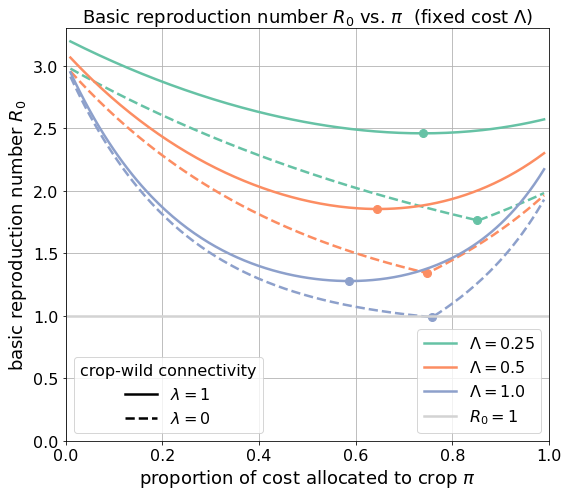

In [34]:
plt.figure(figsize=(8, 7))

# Choose a pastel and colorblind-friendly colormap
cmap = plt.get_cmap('Set2')  # has up to 8 nicely distinguishable pastel colors
colors = [cmap(i) for i in range(len(Lambda_list_short))]

for i, Lambda_total in enumerate(Lambda_list_short):
    y_vals = R0_curves[Lambda_total]
    y_vals_c0 = R0_curves_c0[Lambda_total]
    color = colors[i]
    
    # Plot the curve
    plt.plot(p_vals, y_vals, label=fr'$\Lambda = {Lambda_total}$', ls='-', color=color, lw=lw)
    plt.plot(p_vals, y_vals_c0, ls='--', color=color, lw=lw)
    # Find index of the minimum
    idx_min = np.argmin(y_vals)
    x_min = p_vals[idx_min]
    y_min = y_vals[idx_min]
    
    idx_min_c0 = np.argmin(y_vals_c0)
    x_min_c0 = p_vals[idx_min_c0]
    y_min_c0 = y_vals_c0[idx_min_c0]
    
    # Add marker at the minimum
    plt.plot(x_min, y_min, marker='o', markersize=8, color=color)
    plt.plot(x_min_c0, y_min_c0, marker='o', markersize=8, color=color)

plt.axhline(1.0, color='LightGray', linestyle='-', linewidth=lw, label=r'$R_0 = 1$')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 3.3])

plt.xlabel('proportion of cost allocated to crop $\pi$', fontsize=18)
plt.ylabel(r'basic reproduction number $R_0$', fontsize=18)
plt.title(r'Basic reproduction number $R_0$ vs. $\pi$  (fixed cost $\Lambda$)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(True)
#plt.legend(fontsize=16)

ax = plt.gca()

# Legend 1: curves (uses the labels you already set on plt.plot + R0=1 line)
leg1 = ax.legend(loc="lower right", frameon=True, fontsize=16)
plt.setp(leg1.get_title(), fontsize=16)
ax.add_artist(leg1)  # keep it when adding the second legend

# Legend 2: line styles
from matplotlib.lines import Line2D
legend_lines = [
    Line2D([0], [0], color='black', lw=lw, linestyle='-',  label=r'$\lambda=1$'),
    Line2D([0], [0], color='black', lw=lw, linestyle='--', label=r'$\lambda=0$')
]
leg2 = ax.legend(handles=legend_lines, title='crop-wild connectivity',
                 loc="lower left", frameon=True, fontsize=16)
plt.setp(leg2.get_title(), fontsize=16)

plt.tight_layout()
plt.savefig("./figures/A_R0_vs_pi_lambda1_vs_0.svg", format="svg")
plt.show()

In [35]:
####This code produces Figure S2 for Electronic Supplementary Information
import re
import svgutils.transform as sg
from lxml import etree
import cairosvg

# --- helpers ---
def _to_px(val):
    """Extract numeric value (assumes px if unit missing)."""
    if val is None:
        return 0.0
    s = str(val).strip()
    m = re.match(r"^\s*([0-9.]+)\s*([a-z%]*)\s*$", s)
    if not m:
        return float(s)  # fallback
    num, unit = m.groups()
    num = float(num)
    unit = unit.lower()
    # Simple handling: treat unspecified or 'px' as px
    # (You can extend for 'pt','cm','mm' if needed.)
    return num

# --- load individual panels ---
svgA = sg.fromfile("./figures/A_R0_vs_pi_lambda1_vs_0.svg")
svgB = sg.fromfile("./figures/B_Lambda_vs_pi_lambda_1_vs_0.svg")

rootA = svgA.getroot()
rootB = svgB.getroot()

# Get sizes (strings with units), then to floats (px)
wA, hA = svgA.get_size()  # e.g. ('800px', '600px') or ('800', '600')
wB, hB = svgB.get_size()

wA_px, hA_px = _to_px(wA), _to_px(hA)
wB_px, hB_px = _to_px(wB), _to_px(hB)

# Layout parameters
pad = 40  # horizontal padding between panels (px)
margin = 2  # panel label margin from top-left (px)
fontsize = 18

canvas_w = int(wA_px + pad + wB_px)
canvas_h = int(max(hA_px, hB_px))

# Center vertically if heights differ
yA = int((canvas_h - hA_px) / 2)
yB = int((canvas_h - hB_px) / 2)
xA = 0
xB = int(wA_px + pad)

# Create combined figure with explicit px units and a viewBox
fig = sg.SVGFigure(f"{canvas_w}px", f"{canvas_h}px")
fig.root.set("viewBox", f"0 0 {canvas_w} {canvas_h}")

# Move panels into place
rootA.moveto(xA, yA)
rootB.moveto(xB, yB)

# Add panel labels
# You can adjust weight/size as needed
labelA = sg.TextElement(xA + margin, yA + margin + fontsize, "(A)", size=fontsize, weight="bold")
labelB = sg.TextElement(xB + margin, yB + margin + fontsize, "(B)", size=fontsize, weight="bold")

# Compose and save
fig.append([rootA, rootB, labelA, labelB])
combined_svg_path = "./figures/combined_AB.svg"
fig.save(combined_svg_path)

# Convert to PDF
cairosvg.svg2pdf(url=combined_svg_path, write_to="./figures/FigS2.pdf")

print("Saved:", combined_svg_path, "and ./figures/FigS2.pdf")


Saved: ./figures/combined_AB.svg and ./figures/FigS2.pdf
